# 

In [1]:
%run ../utils-notebook/plot.py
%run ../utils-notebook/load_data.py
%run ../utils-notebook/clustering.py
%run ../utils-notebook/dimensionality_reduction.py
%run ../utils-notebook/validate.py


# hdbscan lambdaごと

In [44]:
import hdbscan
import numpy as np
from sklearn.datasets import make_blobs

# --- 1. データ生成 ---
# 3つのクラスタを持つサンプルデータを生成
n_samples = 500
centers = [(1, 1), (-1, -1), (2, -2)]
X, true_labels = make_blobs(n_samples=n_samples, centers=centers, cluster_std=0.4, random_state=42)

# --- 2. HDBSCANの実行 ---
# クラスタリングを実行し、ツリー情報を取得
min_cluster_size = 15
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            core_dist_n_jobs=-1,
                            gen_min_span_tree=True,
                            ).fit(X)

# --- 3. 特定の階層でクラスタリング結果を抽出する関数 ---

def get_clusters_at_lambda(clusterer, target_lambda):
    """
    HDBSCANの単一リンケージツリーから、指定されたラムダ値に対応する
    距離でカットしたクラスタリング結果（ラベル）を取得する。
    """
    # ラムダ値を距離（イプシロン）に変換
    if target_lambda <= 0:
        # ラムダが0以下は無限大の距離に相当するため、単一のクラスタと見なす
        return np.zeros(len(clusterer.labels_), dtype=int), 1

    epsilon = 1.0 / target_lambda
    
    # 単一リンケージツリーを取得
    # raw_treeは (child1, child2, distance, size) の形式のレコードアレイ
    raw_tree = clusterer.single_linkage_tree_.to_numpy()
    n_points = len(X)
    
    # Union-Find構造の初期化
    # 各点を個別のクラスタとして初期化
    parent = np.arange(n_points)

    def find(i):
        if parent[i] == i:
            return i
        parent[i] = find(parent[i])
        return parent[i]

    def union(i, j, current_label):
        root_i = find(i)
        root_j = find(j)
        if root_i != root_j:
            # ラベル付けのために、親を新しいクラスタIDに設定
            # ここでは単純にインデックスの小さい方を親としてマージ
            if root_i < root_j:
                parent[root_j] = root_i
                return True
            else:
                parent[root_i] = root_j
                return True
        return False

    # 距離の小さい（高密度の、大きなラムダ）結合から順に処理
    # raw_treeは既に距離の昇順（ラムダの降順）でソートされている
    
    # 処理すべきノードID（データ点ID: 0 to n_points-1, クラスタノードID: n_points to n_points + n_clusters - 2）
    # 単一リンケージツリーのレコードは、データ点とクラスタノードの結合イベントを表す
    
    # ノード ID の最大値を取得
    num_nodes = len(raw_tree) + n_points
    
    # 各ノードの親を初期化 (最初はすべて自分自身)
    node_parent = np.arange(num_nodes)

    def find_node(i):
        if node_parent[i] == i:
            return i
        node_parent[i] = find_node(node_parent[i])
        return node_parent[i]

    def union_node(i, j):
        root_i = find_node(i)
        root_j = find_node(j)
        if root_i != root_j:
            # より安定した（高密度の）方を親にしたいが、ここでは単純にインデックスの小さい方を親に
            if root_i < root_j:
                node_parent[root_j] = root_i
                return True
            else:
                node_parent[root_i] = root_j
                return True
        return False

    # クラスタノードID (n_points から始まる)
    cluster_node_id = n_points
    
    # 単一リンケージツリーの結合イベントを順に処理
    for row in raw_tree:
        # child1とchild2は、結合する2つのノードID
        child1, child2, dist, _ = row
        
        # 指定されたイプシロン（距離）より小さい距離での結合のみを考慮
        if dist <= epsilon:
            # 結合を実行
            union_node(int(child1), int(child2))
            
            # このイベントで誕生したクラスタノードIDをインクリメント
            cluster_node_id += 1
        else:
            # 距離がターゲットを超えたため、これ以上は結合しない（カットライン）
            break
            
    # 最終的なラベル付け
    # データ点ID (0からn_points-1) の連結成分ルートIDを取得
    labels = np.zeros(n_points, dtype=int)
    unique_roots = {}
    label_counter = 0

    for i in range(n_points):
        root = find_node(i)
        if root not in unique_roots:
            unique_roots[root] = label_counter
            label_counter += 1
        labels[i] = unique_roots[root]
        
    return labels, label_counter

# --- 4. 実行例 ---

# HDBSCANが自動で選択したラムダ (例: 0.8) に近い値を指定
target_lambda_high_density = 1.0 / clusterer.minimum_spanning_tree_._data.min() * 2 # 適当に高めのラムダ
target_lambda_low_density = 0.5 # 適当に低めのラムダ

# HDBSCANの最終的なラベル
final_labels = clusterer.labels_

# 指定したラムダでのラベルを抽出
labels_high, num_high = get_clusters_at_lambda(clusterer, target_lambda_high_density)
labels_low, num_low = get_clusters_at_lambda(clusterer, target_lambda_low_density)

print(f"--- HDBSCAN 最終クラスタリング ---")
print(f"クラスタ数 (ノイズを除く): {len(np.unique(final_labels[final_labels != -1]))}")

print(f"\n--- 高いλでのカット (局所的な密度のクラスタ) ---")
print(f"対象 λ: {target_lambda_high_density:.2f}")
print(f"抽出されたクラスタ数: {num_high}")
print(f"抽出されたラベルの最初の10点: {labels_high[:10]}")

print(f"\n--- 低いλでのカット (広域的な密度のクラスタ) ---")
print(f"対象 λ: {target_lambda_low_density:.2f}")
print(f"抽出されたクラスタ数: {num_low}")
print(f"抽出されたラベルの最初の10点: {labels_low[:10]}")

--- HDBSCAN 最終クラスタリング ---
クラスタ数 (ノイズを除く): 3

--- 高いλでのカット (局所的な密度のクラスタ) ---
対象 λ: -0.67
抽出されたクラスタ数: 1
抽出されたラベルの最初の10点: [0 0 0 0 0 0 0 0 0 0]

--- 低いλでのカット (広域的な密度のクラスタ) ---
対象 λ: 0.50
抽出されたクラスタ数: 494
抽出されたラベルの最初の10点: [0 1 2 3 4 5 6 7 8 9]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [45]:

lams = [0.01, 0.1, 0.2, 0.3, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 3.0]
for lam in lams:
    labels, num = get_clusters_at_lambda(clusterer, lam)
    print(f"λ={lam}: クラスタ数={num}")

λ=0.01: クラスタ数=494
λ=0.1: クラスタ数=494
λ=0.2: クラスタ数=494
λ=0.3: クラスタ数=494
λ=0.3: クラスタ数=494
λ=0.4: クラスタ数=494
λ=0.5: クラスタ数=494
λ=0.6: クラスタ数=494
λ=0.7: クラスタ数=494
λ=0.8: クラスタ数=494
λ=0.9: クラスタ数=494
λ=1.0: クラスタ数=494
λ=1.5: クラスタ数=494
λ=2.0: クラスタ数=494
λ=3.0: クラスタ数=494


In [47]:
import numpy as np

def extract_clusters_at_lambda(clusterer, target_lambda):
    """
    HDBSCANのsingle_linkage_tree_から、指定λでのクラスタ構造を再現する。
    
    Parameters
    ----------
    clusterer : hdbscan.HDBSCAN
        fit済みのHDBSCANオブジェクト
    target_lambda : float
        切断したいλ値（λ = 1 / 距離）

    Returns
    -------
    labels : np.ndarray
        各サンプルに割り当てられたクラスタラベル
    n_clusters : int
        クラスタ数
    """
    # λ から距離 ε に変換
    if target_lambda <= 0:
        labels = np.zeros(len(clusterer.labels_), dtype=int)
        return labels, 1

    epsilon = 1.0 / target_lambda

    # Single-linkage tree を numpy array で取得
    # 各行は [child1, child2, distance, size]
    linkage = clusterer.single_linkage_tree_.to_numpy()
    
    # データ点数を計算 (linkage配列の行数 + 1)
    n_points = linkage.shape[0] + 1

    # Union-Find 初期化
    parent = np.arange(n_points)

    def find(i):
        if parent[i] != i:
            parent[i] = find(parent[i])
        return parent[i]

    def union(i, j):
        ri, rj = find(i), find(j)
        if ri != rj:
            if ri < rj:
                parent[rj] = ri
            else:
                parent[ri] = rj

    # linkageを距離順に処理し、ε以下の距離でのみ結合
    for child1, child2, dist, _ in linkage:
        if dist <= epsilon:
            union(int(child1), int(child2))
        else:
            break

    # 各点のrootを取得してクラスタラベルに変換
    roots = np.array([find(i) for i in range(n_points)])
    unique_roots, labels = np.unique(roots, return_inverse=True)
    n_clusters = len(unique_roots)

    return labels, n_clusters

In [48]:
import hdbscan
from sklearn.datasets import make_blobs

# サンプルデータ
X, _ = make_blobs(n_samples=500, centers=3, cluster_std=0.4, random_state=42)

# HDBSCAN実行
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True).fit(X)

# λのスケールを決定（MSTから取る）
mst = clusterer.minimum_spanning_tree_
lambda_min = mst._data.min()
lambda_max = mst._data.max()
print(f"λの範囲: {lambda_min:.3f} から {lambda_max:.3f}")
some_min = mst._mst.min()
some_max = mst._mst.max()
print(f"MSTの距離の範囲: {some_min:.3f} から {some_max:.3f}")

# 高密度領域（高λ）で切る
for ratio in [0.2, 0.4, 0.6, 0.8]:
    target_lambda = lambda_max * ratio
    labels, n_clusters = extract_clusters_at_lambda(clusterer, target_lambda)

    print(f"λ={target_lambda:.3f} の時点のクラスタ数: {n_clusters}")

# 可視化
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=labels, cmap="tab10", s=20)
plt.title(f"Clusters at λ={target_lambda:.3f}")
plt.show()


λの範囲: -7.850 から 10.555
MSTの距離の範囲: 0.000 から 499.000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



IndexError: index 500 is out of bounds for axis 0 with size 500

# a

In [57]:
X, y = load_w2v(5000)

/Users/owner/work/DRZoom/src/experiments/17_HDBSCAN
/Users/owner/work/DRZoom/src/experiments/utils-notebook
Number of words in the model: 3000000
shape of vector: (5000, 300)


In [58]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,
                            min_samples=3,

                            gen_min_span_tree=True).fit(X)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
clusterer.single_linkage_tree_.plot()

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_hdbscan_single_linkage_plotly(clusterer, max_nodes=1000, title="HDBSCAN Single Linkage Tree"):
    """
    HDBSCANのSingle Linkage TreeをPlotlyで可視化（大規模データ対応）
    
    Parameters
    ----------
    clusterer : hdbscan.HDBSCAN
        fit済みのHDBSCANオブジェクト
    max_nodes : int
        表示する最大ノード数（メモリ・速度制限のため）
    """
    # Single linkage tree を取得
    linkage = clusterer.single_linkage_tree_.to_numpy()
    n_points = linkage.shape[0] + 1
    
    # データが大きすぎる場合は上位の結合のみを表示
    if len(linkage) > max_nodes:
        # 距離の大きい（後の結合）もののみを表示
        sorted_indices = np.argsort(linkage[:, 2])
        linkage = linkage[sorted_indices[-max_nodes:]]
        print(f"データが大きいため、上位{max_nodes}個の結合のみ表示します")
    
    # ノード位置の計算（簡易版）
    node_positions = {}
    
    # リーフノードの初期位置
    leaves = set(range(n_points))
    for i, leaf in enumerate(leaves):
        node_positions[leaf] = i
    
    # 内部ノードの位置を計算
    cluster_id = n_points
    for child1, child2, dist, size in linkage:
        child1, child2 = int(child1), int(child2)
        
        # 子ノードの位置を取得
        pos1 = node_positions.get(child1, 0)
        pos2 = node_positions.get(child2, 0)
        
        # 親ノードの位置は子ノードの中点
        parent_pos = (pos1 + pos2) / 2
        node_positions[cluster_id] = parent_pos
        
        cluster_id += 1
    
    # Plotlyで描画
    fig = go.Figure()
    
    cluster_id = n_points
    for child1, child2, dist, size in linkage:
        child1, child2 = int(child1), int(child2)
        
        pos1 = node_positions.get(child1, 0)
        pos2 = node_positions.get(child2, 0)
        parent_pos = node_positions[cluster_id]
        
        # L字型の線を描画
        # child1 -> parent
        fig.add_trace(go.Scatter(
            x=[pos1, pos1, parent_pos],
            y=[0, dist, dist],
            mode='lines',
            line=dict(color='black', width=1),
            showlegend=False,
            hoverinfo='text',
            text=f'Merge: {child1}-{child2}<br>Distance: {dist:.3f}<br>Size: {size}'
        ))
        
        # child2 -> parent
        fig.add_trace(go.Scatter(
            x=[pos2, pos2, parent_pos],
            y=[0, dist, dist],
            mode='lines',
            line=dict(color='black', width=1),
            showlegend=False,
            hoverinfo='skip'
        ))
        
        cluster_id += 1
    
    fig.update_layout(
        title=title,
        xaxis_title="Node Index",
        yaxis_title="Distance",
        showlegend=False,
        width=1000,
        height=600
    )
    
    return fig

def plot_condensed_tree_plotly(clusterer, title="HDBSCAN Condensed Tree"):
    """
    HDBSCANのCondensed TreeをPlotlyで可視化
    """
    tree = clusterer.condensed_tree_.to_pandas()
    
    # ノード位置の計算
    node_positions = {}
    leaves = tree[tree['child_size'] == 1]['child'].values
    
    for i, leaf in enumerate(leaves):
        node_positions[leaf] = i
    
    # 内部ノードの位置を計算
    def assign_positions(node_id):
        children = tree[tree['parent'] == node_id]['child'].values
        if len(children) == 0:
            return node_positions.get(node_id, 0)
        
        child_positions = []
        for child in children:
            if child not in node_positions:
                node_positions[child] = assign_positions(child)
            child_positions.append(node_positions[child])
        
        if child_positions:
            node_positions[node_id] = np.mean(child_positions)
        return node_positions[node_id]
    
    # 全ノードの位置を計算
    all_nodes = set(tree['parent'].values) | set(tree['child'].values)
    for node in all_nodes:
        if node not in node_positions:
            assign_positions(node)
    
    # Plotly図を作成
    fig = go.Figure()
    
    # 各エッジを描画
    for _, row in tree.iterrows():
        parent_id = row['parent']
        child_id = row['child']
        lambda_val = abs(row['lambda_val'])
        
        parent_x = node_positions.get(parent_id, 0)
        child_x = node_positions.get(child_id, 0)
        
        # 子のλ値（存在期間の終了）
        child_lambda_end = 0.0
        if row['child_size'] > 1:
            child_rows = tree[tree['parent'] == child_id]
            if len(child_rows) > 0:
                child_lambda_end = abs(child_rows['lambda_val'].min())
        
        # L字型の線を描画
        xs = [child_x, child_x, parent_x]
        ys = [child_lambda_end, lambda_val, lambda_val]
        
        fig.add_trace(go.Scatter(
            x=xs, y=ys,
            mode='lines',
            line=dict(color='blue', width=1),
            showlegend=False,
            hoverinfo='text',
            text=f'Parent: {parent_id}<br>Child: {child_id}<br>λ: {lambda_val:.3f}<br>Size: {row["child_size"]}'
        ))
    
    fig.update_layout(
        title=title,
        xaxis_title="Cluster Index",
        yaxis_title="Lambda (λ)",
        showlegend=False,
        width=1000,
        height=600
    )
    
    return fig

# # 使用例
# # Single linkage tree（トランケート版）
# single_linkage_fig = plot_hdbscan_single_linkage_plotly(clusterer, max_nodes=500)
# single_linkage_fig.show()

# # Condensed tree
# condensed_fig = plot_condensed_tree_plotly(clusterer)
# condensed_fig.show()

In [ ]:
plot_hdbscan_single_linkage_plotly(clusterer, max_nodes=1000).show()

データが大きいため、上位1000個の結合のみ表示します


<Axes: ylabel='$\\lambda$ value'>

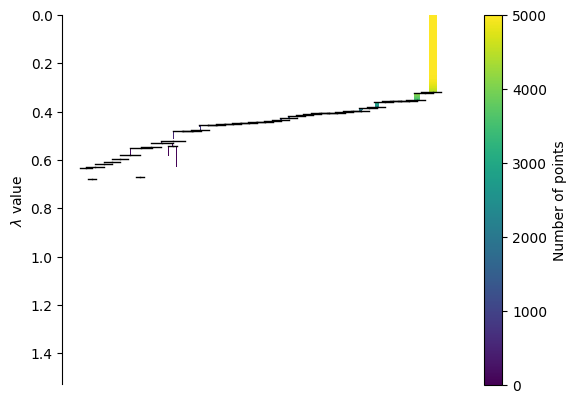

In [ ]:
clusterer.condensed_tree_.plot()

In [ ]:
clusterer.single_linkage_tree_.get_clusters(0.023, min_cluster_size=2)

array([-1, -1, -1, ..., -1, -1, -1])

In [56]:
print(len(clusterer.condensed_tree_.to_pandas()))

508


In [66]:
lams = [0.01, 0.1, 0.2, 0.3, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0,2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 4.0, 5.0]
for lam in lams:
    labels = clusterer.single_linkage_tree_.get_clusters(lam, min_cluster_size=2)
    print(len(labels))
    print(f"λ={lam}: クラスタ数={len(np.unique(labels))}")

5000
λ=0.01: クラスタ数=1
5000
λ=0.1: クラスタ数=1
5000
λ=0.2: クラスタ数=1
5000
λ=0.3: クラスタ数=1
5000
λ=0.3: クラスタ数=1
5000
λ=0.4: クラスタ数=1
5000
λ=0.5: クラスタ数=2
5000
λ=0.6: クラスタ数=2
5000
λ=0.7: クラスタ数=3
5000
λ=0.8: クラスタ数=6
5000
λ=0.9: クラスタ数=8
5000
λ=1.0: クラスタ数=8
5000
λ=1.5: クラスタ数=13
5000
λ=1.6: クラスタ数=15
5000
λ=1.7: クラスタ数=15
5000
λ=1.8: クラスタ数=13
5000
λ=1.9: クラスタ数=15
5000
λ=2.0: クラスタ数=19
5000
λ=2.1: クラスタ数=15
5000
λ=2.2: クラスタ数=20
5000
λ=2.3: クラスタ数=17
5000
λ=2.4: クラスタ数=18
5000
λ=2.5: クラスタ数=19
5000
λ=2.6: クラスタ数=21
5000
λ=2.7: クラスタ数=10
5000
λ=2.8: クラスタ数=8
5000
λ=2.9: クラスタ数=5
5000
λ=3.0: クラスタ数=4
5000
λ=4.0: クラスタ数=2
5000
λ=5.0: クラスタ数=2


In [42]:
proj = run_umap(X)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
print(len(clusterer))

15


In [67]:
labes = clusterer.single_linkage_tree_.get_clusters(2.0, min_cluster_size=2)
print(len(labes))
print(f"unique label: {np.unique(labes)}")

5000
unique label: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


# データセットとパラメータ比較

In [91]:
lams = [1.0, 2.0, 2.2, 2.5, 3.0, 4.0, 5.0]
labels = [clusterer.single_linkage_tree_.get_clusters(lam, min_cluster_size=3) for lam in lams ]
# unique len
for lab in labels:
    print(len(np.unique(lab)))    
plot_hierarchical_scatter(proj, labels, params=lams)

8
12
13
10
4
2
2
n_facets: 7


In [2]:
X, y = load_mnist(5000)

MNIST dataset loaded with 70000 samples and 784 features.
Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [ ]:
import numpy as np
import plotly.express as px
from sklearn.preprocessing import normalize
import umap

import plotly.graph_objects as go
def run_hdbscan(X, 
                y, 
                min_samples=25, 
                min_cluster_size=5, 
                max_cluster_size=1000,
                n_neighbors=100, 
                min_dist=1e-3, 
                spread=2.0, 
                n_epochs=500):
    X = normalize(X)
    hdbscan_model = hdbscan.HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
        max_cluster_size=max_cluster_size,
        cluster_selection_method='leaf'
    )
    labels = hdbscan_model.fit_predict(X)
    hdbscan_model.condensed_tree_.plot()
    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        spread=spread,
        n_epochs=n_epochs,
        random_state=42
    )
    embeddings = umap_model.fit_transform(X)

    print(f"クラスタ数: {len(np.unique(labels))}")
    print(f"ノイズ割合: {np.mean(labels == -1):.2%}")

    df = {
        'x': embeddings[:, 0],
        'y': embeddings[:, 1],
        'label': labels.astype(str)
    }

    fig = px.scatter(
        df,
        x='x',
        y='y',
        color='label',
        title='HDBSCAN + UMAP クラスタリング可視化',
        color_continuous_scale='Viridis',
        opacity=0.7,
    )
    fig.update_traces(marker=dict(size=3))
    fig.show()

    

    # ===== ヒストグラム計算 =====
    unique_labels = np.unique(labels)
    counts = np.array([np.sum(labels == l) for l in unique_labels])

    # ===== Plotlyで可視化 =====
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=unique_labels,
        y=counts,
        marker_color='blue',
        name='Cluster Size'
    ))

    fig.update_layout(
        title='HDBSCAN Cluster Size Distribution',
        xaxis_title='Cluster Label',
        yaxis_title='Number of Points',
        template='plotly_white'
    )

    fig.show()

    print
    # ===== 各クラスタの上位単語を表示（最初の10個） =====
    for c in range(0, 10):
        # labels == c のインデックスを取得
        indices = np.where(labels == c)[0][:10]  # 上位10個
        words = [y[i] for i in indices]
        print(f"Cluster: {c}, {words}")

    print("\n===== 各クラスタの上位単語をHDBSCANの確率でソートして表示 =====")
    # ===== 各クラスタをHDBSCANの確率でソートして表示 =====
    for c in range(0, 25):
        indices = np.where(labels == c)[0]
        # ラベル内の確率で降順ソート
        indices_sorted = sorted(indices, key=lambda x: 1 - hdbscan_model.probabilities_[x])
        words = [y[i] for i in indices_sorted[:10]]  # 上位10個
        print(f"Cluster: {c}, {words}")


In [ ]:
X, y = load_w2v(5000)


c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



クラスタ数: 30
ノイズ割合: 90.32%


Cluster: 0, ['oil', 'energy', 'gas', 'electricity', 'natural_gas', 'coal']
Cluster: 1, ['C', 'B', 'M', 'E', 'S', 'G', 'J']
Cluster: 2, ['online', 'Internet', 'Web', 'web', 'websites']
Cluster: 3, ['north', 'south', 'southern', 'northern', 'west', 'east', 'western', 'eastern']
Cluster: 4, ['technology', 'software', 'systems', 'solutions', 'technologies', 'innovative', 'methods']
Cluster: 5, ['flight', 'airport', 'aircraft', 'flights', 'airline', 'planes']
Cluster: 6, ['president', 'director', 'manager', 'chief', 'executive', 'CEO', 'chairman', 'vice_president', 'Director', 'chief_executive']
Cluster: 7, ['sales', 'buy', 'sold', 'sale', 'sell', 'purchase', 'buying', 'bought', 'purchased', 'purchases']
Cluster: 8, ['company', 'companies', 'industry', 'investment', 'investors', 'banks', 'stores', 'firms', 'investments', 'industries']
Cluster: 9, ['China', 'United_States', 'countries', 'India', 'Europe', 'British', 'Australia', 'Japan', 'Chinese', 'Germany']
Cluster: 0, ['oil', 'energy', 'g

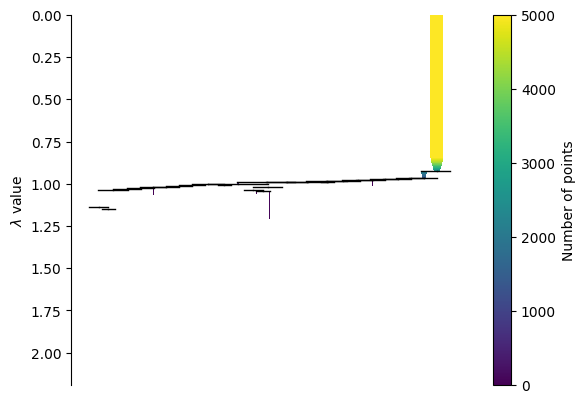

In [15]:
run_hdbscan(X, y, min_samples=10, min_cluster_size=5)

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



クラスタ数: 91
ノイズ割合: 83.76%


Cluster: 0, ['dog', 'fish', 'animals', 'dogs', 'animal', 'trees', 'birds', 'horses']
Cluster: 1, ['items', 'clothing', 'dress']
Cluster: 2, ['power', 'water', 'oil', 'energy', 'gas', 'fuel', 'electricity', 'Oil', 'barrel', 'Power']
Cluster: 3, ['&', 'C', 'B', 'T', 'M', 'P', 'E', 'S', 'G', 'F']
Cluster: 4, ['media', 'press', 'reporters']
Cluster: 5, ['film', 'movie', 'actor', 'actors']
Cluster: 6, ['music', 'band', 'album', 'song', 'songs', 'singer', 'musical', 'CD']
Cluster: 7, ['TV', 'television', 'cable', 'ABC', 'broadband']
Cluster: 8, ['video', 'picture', 'photo', 'photos', 'images', 'pictures', 'videos']
Cluster: 9, ['car', 'vehicle', 'driving', 'cars', 'driver', 'vehicles', 'truck', 'trucks', 'buses']
Cluster: 0, ['animals', 'dogs', 'animal', 'dog', 'horses', 'trees', 'birds', 'fish']
Cluster: 1, ['items', 'clothing', 'dress']
Cluster: 2, ['oil', 'electricity', 'natural_gas', 'gasoline', 'crude', 'gas', 'barrel', 'barrels', 'energy', 'Oil']
Cluster: 3, ['C', 'S', 'J', 'B', 'M', '

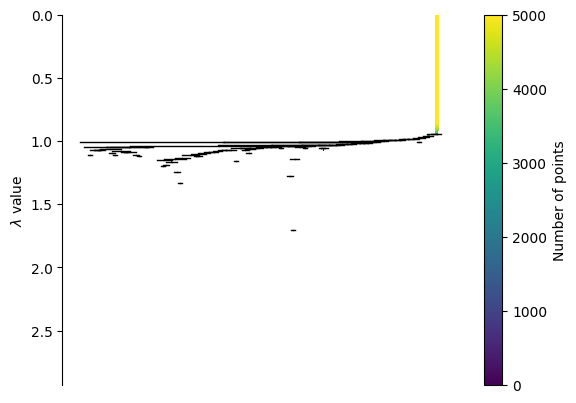

In [16]:
run_hdbscan(X, y , min_samples=5, min_cluster_size=3)

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



クラスタ数: 9
ノイズ割合: 90.42%


Cluster: 0, ['Florida', 'Chicago', 'Los_Angeles', 'Ohio', 'Boston', 'Michigan', 'Arizona', 'Detroit', 'Minnesota', 'Houston']
Cluster: 1, ['China', 'United_States', 'Iraq', 'countries', 'India', 'Europe', 'European', 'Australia', 'Japan', 'Iran']
Cluster: 2, ['government', 'police', 'Senate', 'arrested', 'Democrats', 'Democratic', 'legislation', 'Republicans', 'lawmakers', 'convicted']
Cluster: 3, ['John', 'David', 'Michael', 'James', 'Paul', 'Mike', 'Mark', 'Chris', 'Scott', 'Bill']
Cluster: 4, ['Smith', 'Johnson', 'Brown', 'Williams', 'Jones', 'Davis', 'Miller', 'Taylor', 'Wilson', 'Anderson']
Cluster: 5, ['market', 'companies', 'sales', 'growth', 'products', 'businesses', 'systems', 'firms', 'investments', 'suppliers']
Cluster: 6, ['that', 'is', '##', 'The', 'said', 'not', 'it', 'I', 'have', 'will']
Cluster: 7, ['after', 'week', 'Friday', 'month', 'Tuesday', 'Monday', 'Thursday', 'Wednesday', 'Saturday', 'Sunday']
Cluster: 8, []
Cluster: 9, []
Cluster: 0, ['Chicago', 'Oklahoma', 'Or

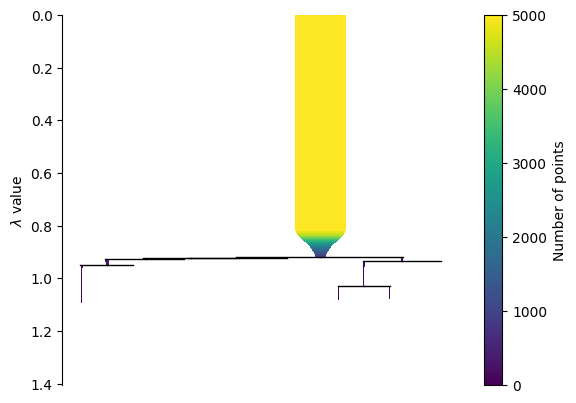

In [17]:
run_hdbscan(X, y, min_samples=25, min_cluster_size=10)

In [23]:
X, y = load_w2v(5000)

d:\Work_Research\DRZoom\src\experiments\17_HDBSCAN
d:\Work_Research\DRZoom\src\experiments\utils-notebook
Number of words in the model: 3000000
shape of vector: (5000, 300)


c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



クラスタ数: 11
ノイズ割合: 90.34%


c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Cluster: 0, ['director', 'executive', 'chairman', 'vice_president', 'Chairman']
Cluster: 1, ['Florida', 'Chicago', 'Los_Angeles', 'Ohio', 'Boston', 'Michigan', 'Arizona', 'Detroit', 'Minnesota', 'Houston']
Cluster: 2, ['China', 'United_States', 'Iraq', 'countries', 'India', 'Europe', 'European', 'Australia', 'Japan', 'Iran']
Cluster: 3, ['John', 'David', 'Michael', 'James', 'Paul', 'Mike', 'Mark', 'Chris', 'Scott', 'Bill']
Cluster: 4, ['Smith', 'Johnson', 'Brown', 'Williams', 'Jones', 'Davis', 'Miller', 'Taylor', 'Wilson', 'Anderson']
Cluster: 5, ['police', 'arrested', 'convicted', 'investigators', 'prosecutors', 'prosecution']
Cluster: 6, ['government', 'Senate', 'Democrats', 'Democratic', 'legislation', 'Republicans', 'lawmakers', 'legislative', 'legislators']
Cluster: 7, ['market', 'companies', 'sales', 'growth', 'products', 'businesses', 'systems', 'firms', 'investments', 'suppliers']
Cluster: 8, ['that', 'is', '##', 'The', 'said', 'not', 'it', 'I', 'have', 'will']
Cluster: 9, ['af

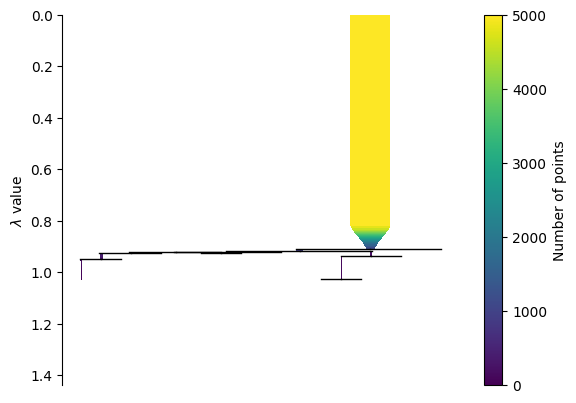

In [24]:
run_hdbscan(X, y)

In [22]:
X, y = load_fmnist(5000)
run_hdbscan(X, y, min_samples=10, min_cluster_size=5)

Fashion-MNIST dataset loaded with 70000 samples and 784 features.
Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



KeyboardInterrupt: 

In [3]:
import numpy as np
import plotly.graph_objects as go
from warnings import warn
from hdbscan.plots import CondensedTree # 実際の環境ではこちらを使用
# from hdbscan import HDBSCAN # 実際の環境ではこちらを使用
# from sklearn.datasets import make_blobs # 実際の環境ではこちらを使用

# --- HDBSCAN内部の定数 (CondensedTree.get_plot_dataで使用) ---
CB_LEFT = 0
CB_RIGHT = 1
CB_BOTTOM = 2
CB_TOP = 3

# --- ユーザー提供のコードに基づいてPlotlyで描画する関数 ---
def plot_condensed_tree_plotly(condensed_tree,
                              select_clusters=True,
                              log_size=False,
                              cmap='Viridis', # Plotly互換のカラーマップ
                              selection_color='red',
                              fig_title='HDBSCAN Condensed Tree (Plotly)'):
    """
    hdbscan.plots.CondensedTreeオブジェクトを使用してPlotlyでIcicle Plotを描画します。

    Parameters
    ----------
    condensed_tree : hdbscan.plots.CondensedTree
        HDBSCANクラスタリング結果のCondensedTreeオブジェクト。
    select_clusters : bool, optional
        HDBSCANによって選択された安定したクラスタをハイライト表示するかどうか。
    log_size : bool, optional
        クラスターサイズ（幅）を対数スケールで表示するかどうか。
    cmap : str, optional
        クラスターサイズを色付けするためのPlotlyカラーマップ名。
    selection_color : str, optional
        選択されたクラスタのハイライト色。
    fig_title : str, optional
        グラフのタイトル。
    """
    
    # 1. CondensedTreeから描画データを取得
    # get_plot_dataは、x軸とy軸の座標、幅、高さなど、すべてのプロット要素を計算します。
    plot_data = condensed_tree.get_plot_data(log_size=log_size)
    
    bar_centers = plot_data['bar_centers']
    bar_tops = plot_data['bar_tops']
    bar_bottoms = plot_data['bar_bottoms']
    bar_widths = plot_data['bar_widths']
    line_xs = plot_data['line_xs']
    line_ys = plot_data['line_ys']
    cluster_bounds = plot_data['cluster_bounds']

    if not bar_widths:
        warn("描画するバーがCondensed Treeに見つかりませんでした。", UserWarning)
        return go.Figure()

    # 2. Plotly Figureの作成とカラーマッピング
    fig = go.Figure()
    max_width = np.max(bar_widths)

    # 3. 「icicle plot」のバー (go.Bar) を追加
    bar_trace = go.Bar(
        x=bar_centers,
        y=np.array(bar_tops) - np.array(bar_bottoms), # バーの高さ (Top - Bottom)
        base=bar_bottoms, # バーの底の位置
        width=bar_widths,
        marker=dict(
            color=bar_widths, # 幅に基づいて色付け
            colorscale=cmap,
            cmin=0,
            cmax=max_width,
            colorbar=dict(
                title='log(ポイント数)' if log_size else 'ポイント数',
                title_font=dict(size=10)
            )
        ),
        opacity=1.0,
        showlegend=False,
        name='Cluster Persistence',
        hoverinfo='skip'
    )
    fig.add_trace(bar_trace)

    # 4. 枝分かれの線 (go.Scatter) を追加
    # PlotlyのScatterトレース（モード='lines'）を使用。線セグメントの間にNoneを挿入して分離します。
    all_line_x = []
    all_line_y = []
    
    for xs, ys in zip(line_xs, line_ys):
        all_line_x.extend(xs)
        all_line_y.extend(ys)
        all_line_x.append(None)
        all_line_y.append(None)
        
    line_trace = go.Scatter(
        x=all_line_x,
        y=all_line_y,
        mode='lines',
        line=dict(color='black', width=1),
        hoverinfo='skip',
        showlegend=False,
        name='Cluster Splits'
    )
    fig.add_trace(line_trace)

    # 5. 選択されたクラスタのハイライト（矩形シェイプ）
    if select_clusters:
        try:
            chosen_clusters = condensed_tree._select_clusters()
        except Exception as e:
            warn(f"クラスタを選択できませんでした: {e}. ハイライトをスキップします。")
            chosen_clusters = []
            
        for c in chosen_clusters:
            if c in cluster_bounds:
                c_bounds = cluster_bounds[c]
                
                # 矩形シェイプ (x0=左端, y0=上端, x1=右端, y1=下端)
                fig.add_shape(
                    type="rect",
                    x0=c_bounds[CB_LEFT],
                    y0=c_bounds[CB_TOP],
                    x1=c_bounds[CB_RIGHT],
                    y1=c_bounds[CB_BOTTOM],
                    line=dict(color=selection_color, width=2, dash="dash"),
                    fillcolor="rgba(0,0,0,0)",
                    layer="below"
                )

    # 6. レイアウトの設定
    fig.update_layout(
        title=fig_title,
        xaxis=dict(
            title='',
            showticklabels=False, # X軸ラベルを非表示
            zeroline=False,
            showgrid=False
        ),
        yaxis=dict(
            title='$\\lambda$ value',
            autorange='reversed' # Y軸を反転 (lambda値の小さい方が上になるように)
        ),
        barmode='overlay',
        template="plotly_white",
        height=600,
        width=800
    )

    return fig

### 使用例

import numpy as np
import plotly.graph_objects as go
from sklearn.datasets import make_blobs
from hdbscan import HDBSCAN # hdbscanのインポート
from hdbscan.plots import CondensedTree # hdbscan.plots.CondensedTreeのインポート

# 1. ダミーデータの生成
data, labels = make_blobs(n_samples=500, centers=4, cluster_std=0.7, random_state=42)

# 2. HDBSCANの実行
# min_cluster_sizeを小さくして、より多くの枝分かれを生成
clusterer = HDBSCAN(min_cluster_size=10, prediction_data=True).fit(data)

# 3. CondensedTreeオブジェクトを取得
condensed_tree_obj = clusterer.condensed_tree_

# 4. Plotly描画関数を実行
# log_size=Trueに設定して、サイズを対数スケールで表示
plotly_fig = plot_condensed_tree_plotly(
    condensed_tree=condensed_tree_obj,
    select_clusters=True,
    log_size=True,
    cmap='Plasma',
    selection_color='#E74C3C' # 赤
)

# 5. グラフの表示 (Jupyter Notebookなどで実行)
plotly_fig.show()

# 6. log_size=Falseの例
# plotly_fig_linear = plot_condensed_tree_plotly(
#     condensed_tree=condensed_tree_obj,
#     log_size=False,
#     cmap='Viridis',
#     fig_title='HDBSCAN Condensed Tree (Linear Size Scale)'
# )
# plotly_fig_linear.show()

c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\acero\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
